In [37]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from lifelines import CoxPHFitter 
import forestplot as fb

In [34]:
df = pd.read_csv('NPAR6.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,alcoholic,biliary,drug_induced,unspecified,mortality_7d,mortality_28d,mortality_90d,mortality_1y,has_kidney_disease,has_sepsis
0,19753686,29945708,30469520,2152-04-07T19:23:59,UNKNOWN,M,50,0,0,4.701343,...,0,1,1,1,0,0,0,0,0,0
1,10442603,23644640,31663173,2125-02-25T15:33:43,UNKNOWN,M,67,1,1,1.110764,...,1,0,0,1,1,1,1,1,0,1
2,15696172,21774504,36542183,2187-02-07T00:52:41,UNKNOWN,M,63,1,1,1.417917,...,0,0,0,1,1,1,1,1,0,1
3,19352969,21921993,34589708,2180-10-06T13:15:00,WHITE,F,67,1,1,1.496956,...,0,1,0,1,1,1,1,1,0,0
4,13734425,25179112,35877842,2132-09-06T09:00:00,WHITE,F,91,1,1,2.088681,...,0,1,0,1,1,1,1,1,0,0


$$NPAR = \frac{neutrophils}{albumin}$$

In [6]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'race', 'gender', 'age',
       'mortality_icu', 'mortality_hosp', 'los', 'hosp_los', 'icu_los',
       'admittime', 'dod', 'inr_max', 'pt_max', 'ptt_max',
       'abs_neutrophils_max', 'abs_lymphocytes_max', 'abs_monocytes_max',
       'glucose_max', 'hematocrit_max', 'wbc_max', 'aniongap_max',
       'creatinine_max', 'sodium_max', 'potassium_max', 'bilirubin_total_max',
       'neutrophis_max', 'bun_min', 'albumin_min', 'platelets_min',
       'bicarbonate_min', 'calcium_min', 'hemoglobin_min', 'ast_max',
       'alp_max', 'bun_max', 'chloride_max', 'rdw_max', 'hdl', 'ldl',
       'cholesterol', 'triglycerides', 'alt_max', 'total_protein_max',
       'amylase_max', 'lipase', 'NPAR', 'SII', 'NLR', 'PLR', 'LMR', 'NPR',
       'SIRI', 'sapsii', 'oasis', 'sofa', 'cci', 'apsiii', 'heart_rate_mean',
       'resp_rate_mean', 'mbp_mean', 'temperature_mean', 'spo2_mean',
       'myocardial_infarct', 'congestive_heart_failure',
       'cere

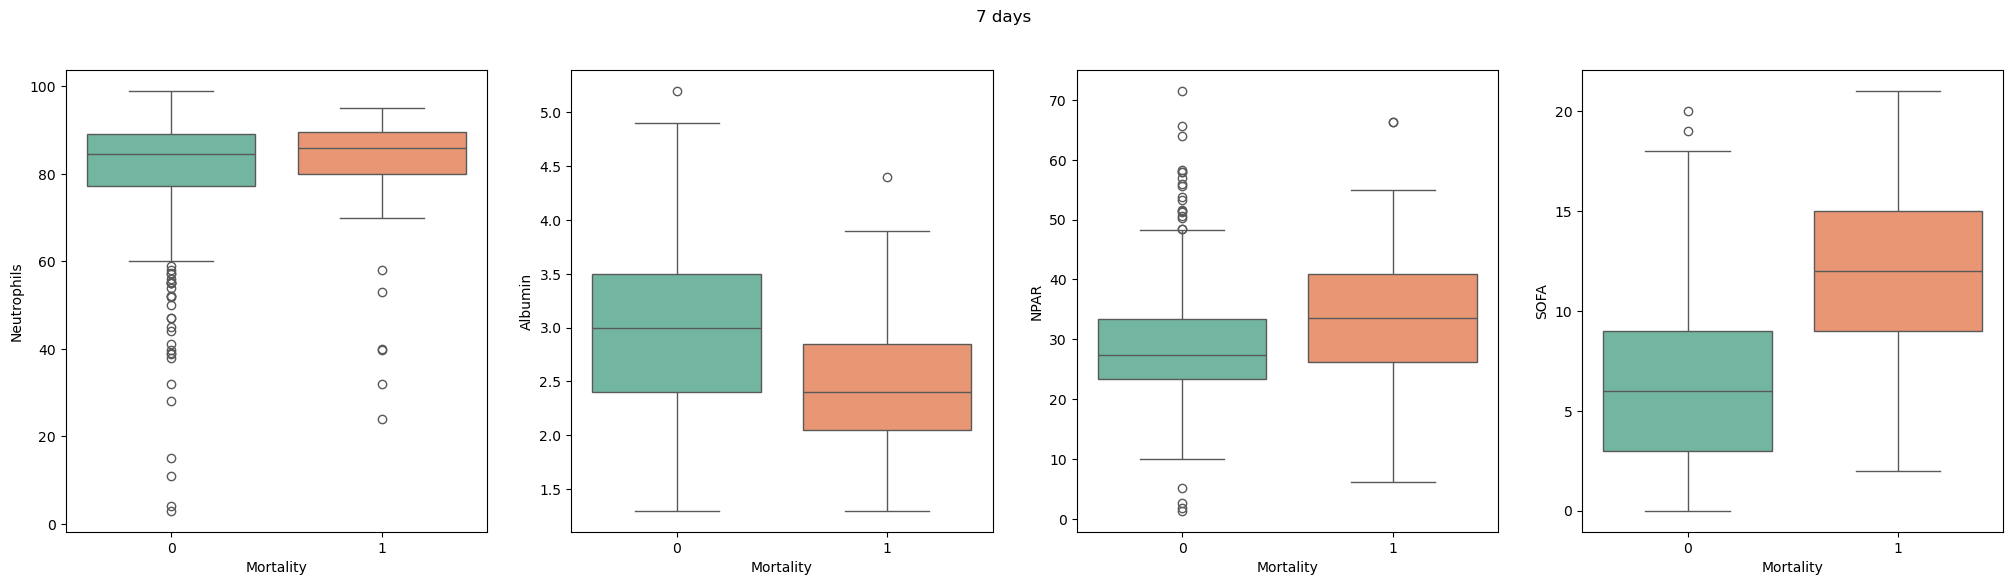

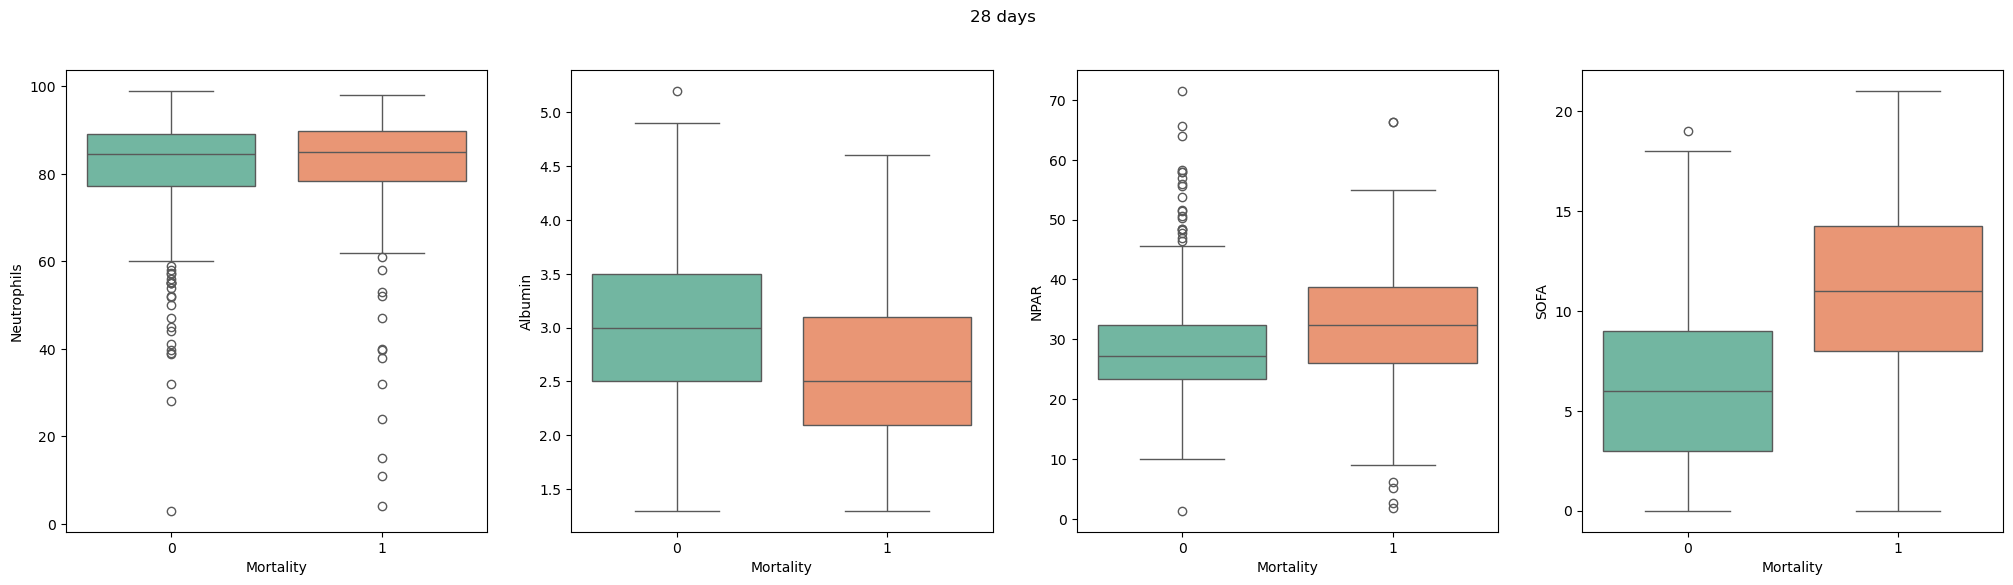

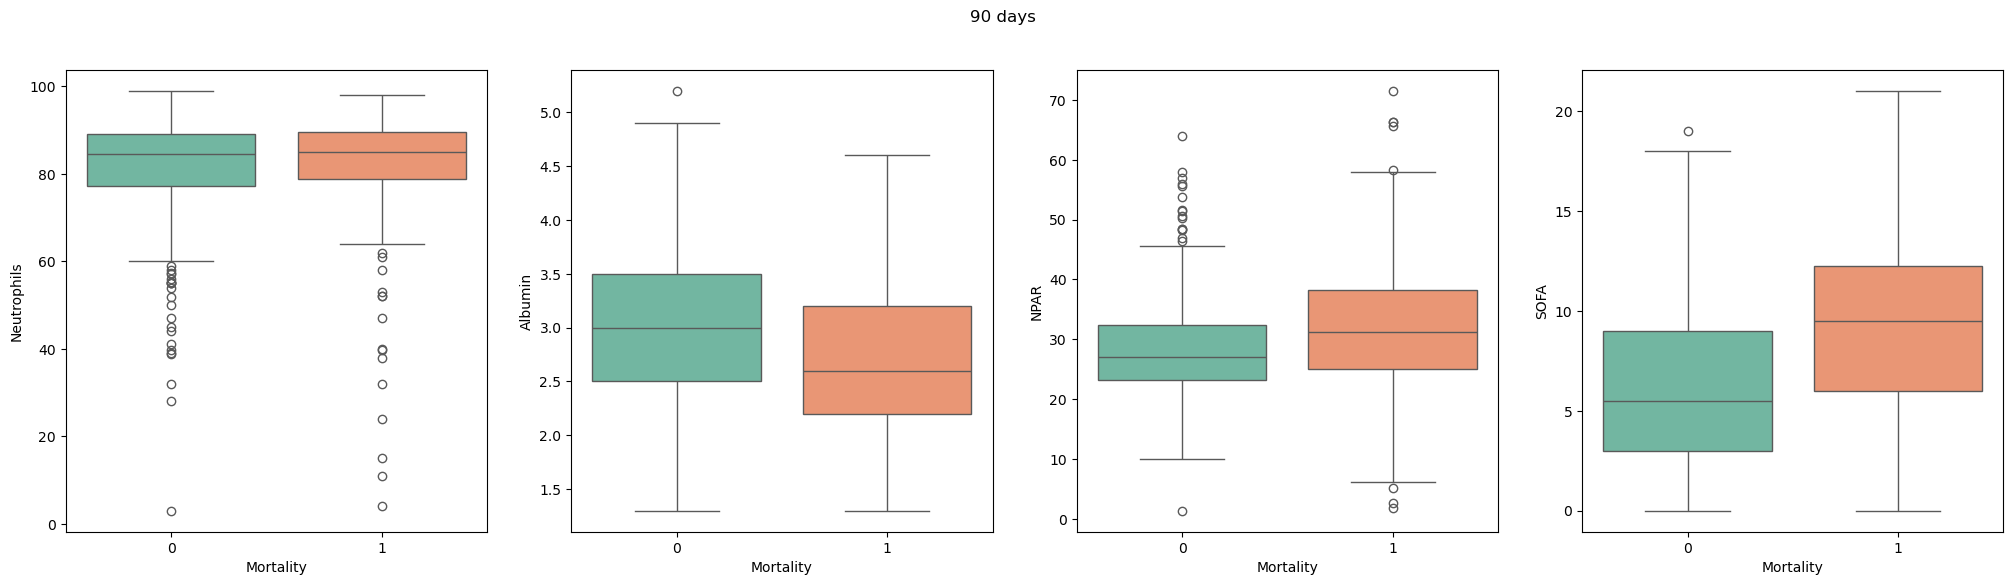

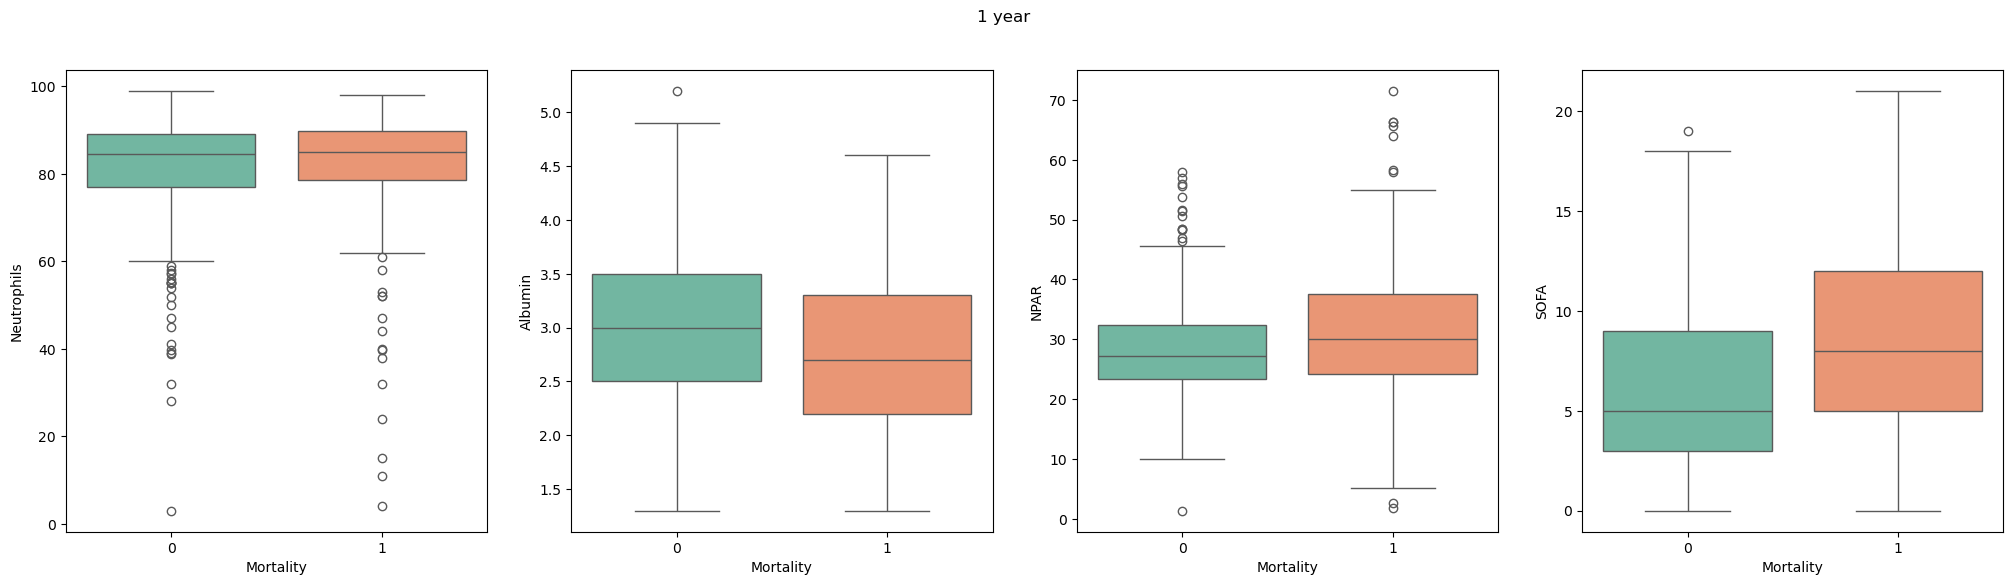

In [29]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophis_max', 'albumin_min', 'NPAR', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']
palette = sns.palettes.color_palette('Set2', n_colors=2)

for j in range(len(col_mortalities)):
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(25, 6))
    for i in range(len(cols)):
        ax = axes[i]
        sns.boxplot(data=df, x=col_mortalities[j], y=cols[i], palette=palette, legend=False, hue=col_mortalities[j], ax=ax)
        # sns.swarmplot(data=df, x=col_mortalities[j], y=cols[i], palette=palette, legend=False, hue=col_mortalities[j], ax=ax)
        # sns.violinplot(data=df, x=col_mortalities[j], y=cols[i], palette=palette, legend=False, hue=col_mortalities[j], ax=ax)
        ax.set_ylabel(titles[i])
        ax.set_xlabel('Mortality')
    fig.suptitle(days[j])
plt.show()


In [ ]:
X = df[['NPAR']]
y = df['mortality_28d']
X.shape, y.shape

((628, 1), (628,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_prob = rfc.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
auc_score, rfc.score(X_test, y_test)


(0.6501424501424502, 0.7515923566878981)

In [22]:
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=2026),
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [2, 3, 4],
        'class_weight': ['balanced', 'balanced_subsample'],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [3, 4, 5]
    }, cv=5, verbose=1
)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


({'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 4,
  'min_samples_leaf': 3,
  'min_samples_split': 2},
 0.7240985442329226)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
rfc = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=4, min_samples_leaf=3, min_samples_split=2)
rfc.fit(X_train, y_train)
y_prob = rfc.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
auc_score, rfc.score(X_test, y_test)


(0.6796296296296296, 0.7006369426751592)

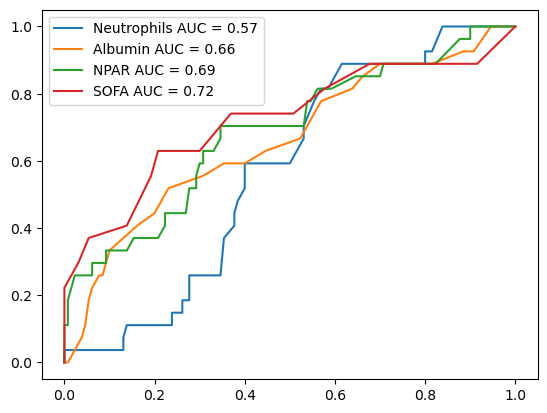

In [24]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophis_max', 'albumin_min', 'NPAR', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']
rfc = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=4, min_samples_leaf=3, min_samples_split=2)

y = df['mortality_28d']
for i in range(len(cols)):
    X = df[[cols[i]]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
    rfc.fit(X_train, y_train)
    y_prob = rfc.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
    auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
    plt.plot(fpr, tpr, label=f'{titles[i]} AUC = {auc_score:.2f}')
plt.legend()
plt.show()


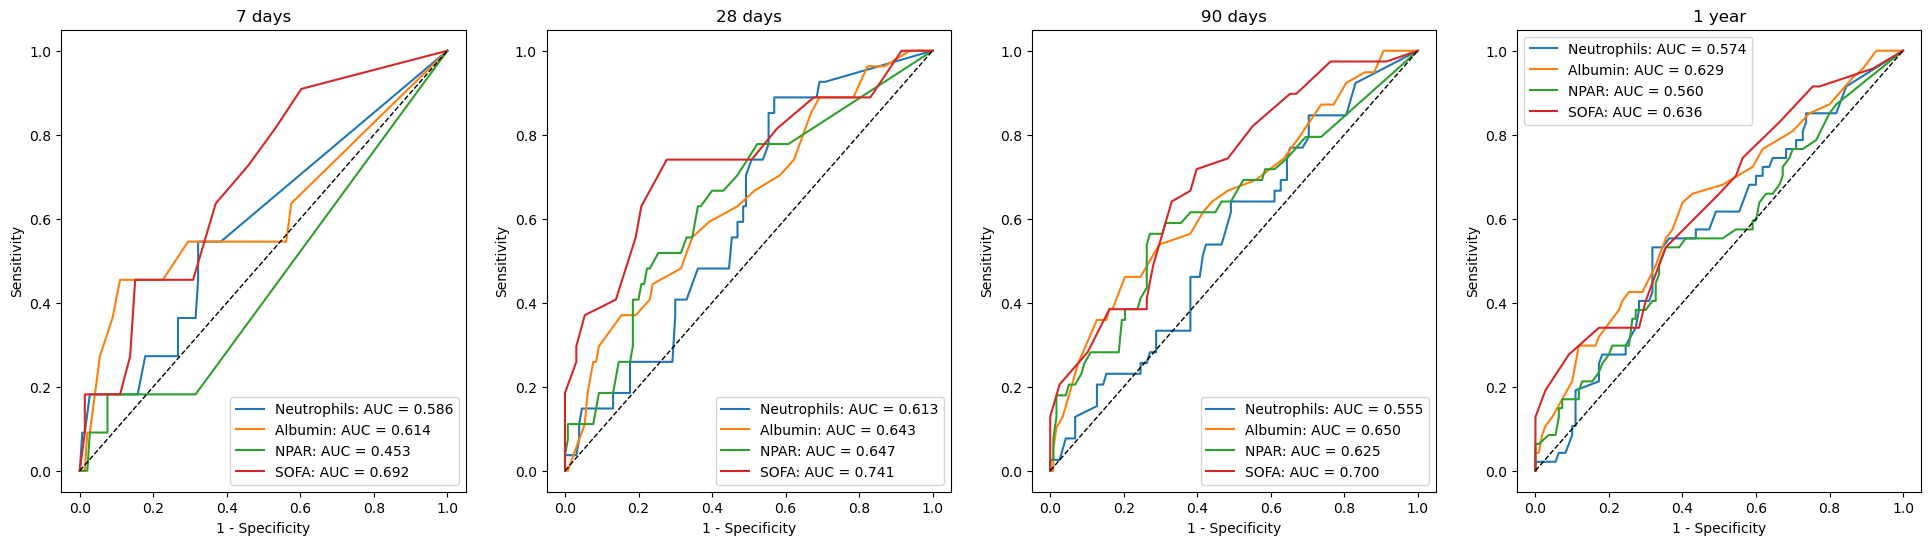

In [25]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophis_max', 'albumin_min', 'NPAR', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']
rfc = RandomForestClassifier(random_state=2026)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
for j in range(len(days)):
    y = df[col_mortalities[j]]
    ax = axes[j]
    for i in range(len(cols)):
        X = df[[cols[i]]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        rfc.fit(X_train, y_train)
        y_prob = rfc.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
        auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
        ax.plot(fpr, tpr, label=f'{titles[i]}: AUC = {auc_score:.3f}')
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    ax.set_title(days[j])
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.legend()
plt.show()


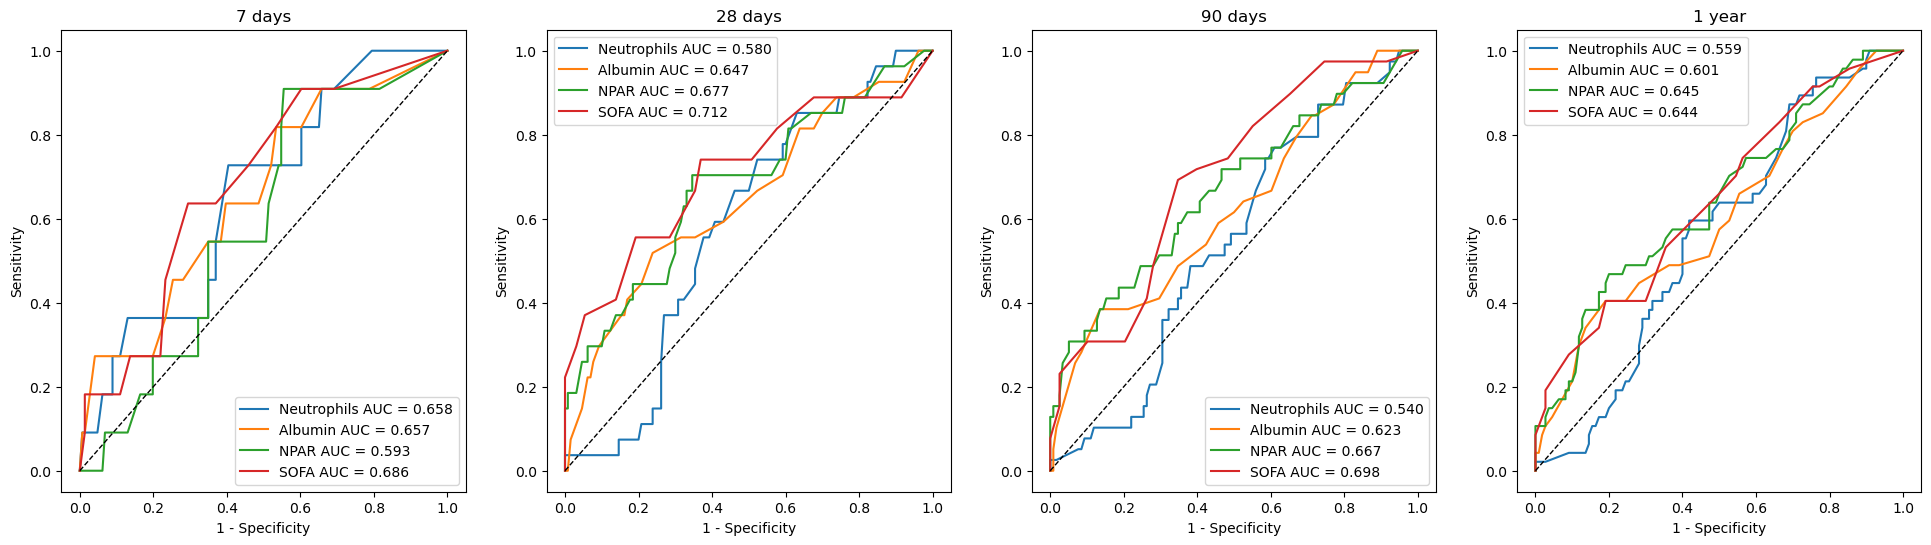

In [26]:
col_mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
days = ['7 days', '28 days', '90 days', '1 year']
cols = ['neutrophis_max', 'albumin_min', 'NPAR', 'sofa']
titles = ['Neutrophils', 'Albumin', 'NPAR', 'SOFA']

rfc = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=4,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=2026
)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

for j in range(len(days)):
    y = df[col_mortalities[j]]
    ax = axes[j]
    for i in range(len(cols)):
        X = df[[cols[i]]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        rfc.fit(X_train, y_train)
        y_prob = rfc.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
        auc_score = roc_auc_score(y_true=y_test, y_score=y_prob)
        ax.plot(fpr, tpr, label=f'{titles[i]} AUC = {auc_score:.3f}')
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    ax.set_title(days[j])
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.legend()

plt.show()


In [ ]:
# pip install forestplot

In [36]:
df['duration_7d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 7), 7, df['los'])
df['duration_28d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 28), 28, df['los'])
df['duration_90d'] = np.where((df['mortality_90d'] == 0) & (df['los'] > 90), 90, df['los'])
df['duration_1y']  = np.where((df['mortality_1y']  == 0) & (df['los'] > 365), 365, df['los'])

In [38]:
df['gender_M'] = df['gender'].map({'M': 1, 'F': 0})
df['gender_F'] = df['gender'].map({'M': 0, 'F': 1})

In [53]:
#age < 70
df['age_lt_70'] = df['age'].map(lambda v: 1 if v < 70 else 0)
#age >= 70
df['age_ge_70'] = df['age'].map(lambda v: 1 if v >= 70 else 0)
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,duration_7d,duration_28d,duration_90d,duration_1y,gender_M,gender_F,age_0,age_1,age_lt_70,age_ge_70
0,19753686,29945708,30469520,2152-04-07T19:23:59,UNKNOWN,M,50,0,0,4.701343,...,4.701343,4.701343,4.701343,4.701343,1,0,1,0,1,0
1,10442603,23644640,31663173,2125-02-25T15:33:43,UNKNOWN,M,67,1,1,1.110764,...,1.110764,1.110764,1.110764,1.110764,1,0,1,0,1,0
2,15696172,21774504,36542183,2187-02-07T00:52:41,UNKNOWN,M,63,1,1,1.417917,...,1.417917,1.417917,1.417917,1.417917,1,0,1,0,1,0
3,19352969,21921993,34589708,2180-10-06T13:15:00,WHITE,F,67,1,1,1.496956,...,1.496956,1.496956,1.496956,1.496956,0,1,1,0,1,0
4,13734425,25179112,35877842,2132-09-06T09:00:00,WHITE,F,91,1,1,2.088681,...,2.088681,2.088681,2.088681,2.088681,0,1,0,1,0,1


In [54]:
results = []

In [55]:
cph = CoxPHFitter()
cph.fit(df = df, duration_col = 'duration_28d', event_col = 'mortality_28d', formula = 'gender_M + NPAR + age_lt_70 * NPAR')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender_M,0.179895,1.197092,0.198445,-0.209050,0.568840,0.811355,1.766217,0.0,0.906523,0.364659,1.455380
NPAR,0.038582,1.039336,0.012892,0.013313,0.063851,1.013402,1.065933,0.0,2.992617,0.002766,8.498000
age_lt_70,-0.019468,0.980721,0.629554,-1.253370,1.214435,0.285541,3.368390,0.0,-0.030923,0.975331,0.036036
age_lt_70:NPAR,-0.024139,0.976150,0.018200,-0.059811,0.011533,0.941943,1.011600,0.0,-1.326291,0.184743,2.436407


In [43]:
hr = cph.summary.loc['gender_M:NPAR', 'exp(coef)']
ll = cph.summary.loc['gender_M:NPAR', 'exp(coef) lower 95%']
hl = cph.summary.loc['gender_M:NPAR', 'exp(coef) upper 95%']
p = cph.summary.loc['gender_M:NPAR', 'p']
results.append({
    'label': '',
    'group': 'Gender',
    'hr': round(hr,2),
    'll': round(ll,2),
    'hl': round(hl,2),
    'p-value': '',
    'p-interaction': '<0.001' if p < 0.001 else round(p,3)
})
results

[{'label': '',
  'group': 'Gender',
  'hr': 1.05,
  'll': 1.01,
  'hl': 1.09,
  'p-value': '',
  'p-interaction': 0.012}]

In [56]:
cph = CoxPHFitter()
cph.fit(df = df, duration_col = 'duration_28d', event_col = 'mortality_28d', formula = 'age_lt_70 + NPAR')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age_lt_70,-0.795013,0.451575,0.198375,-1.183820,-0.406206,0.306107,0.666173,0.0,-4.007631,0.000061,13.993031
NPAR,0.024838,1.025149,0.009091,0.007019,0.042657,1.007044,1.043580,0.0,2.732067,0.006294,7.311844


In [50]:
hr = cph.summary.loc['gender_M', 'exp(coef)']
ll = cph.summary.loc['gender_M', 'exp(coef) lower 95%']
hl = cph.summary.loc['gender_M', 'exp(coef) upper 95%']
p = cph.summary.loc['gender_M', 'p']
results.append({
    'label': 'Male',
    'group': 'Gender',
    'hr': round(hr,2),
    'll': round(ll,2),
    'hl': round(hl,2),
    'p-value': '',
    'p-interaction': '<0.001' if p < 0.001 else round(p,3)
})
results

[{'label': '',
  'group': 'Gender',
  'hr': 1.05,
  'll': 1.01,
  'hl': 1.09,
  'p-value': '',
  'p-interaction': 0.012},
 {'label': '',
  'group': 'Gender',
  'hr': 1.12,
  'll': 0.76,
  'hl': 1.65,
  'p-value': '',
  'p-interaction': 0.56},
 {'label': 'Male',
  'group': 'Gender',
  'hr': 1.12,
  'll': 0.76,
  'hl': 1.65,
  'p-value': '',
  'p-interaction': 0.56}]

In [57]:
cph = CoxPHFitter()
cph.fit(df = df, duration_col = 'duration_28d', event_col = 'mortality_28d', formula = 'age_ge_70 + NPAR')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age_ge_70,0.795013,2.214469,0.198375,0.406206,1.183820,1.501111,3.26683,0.0,4.007631,0.000061,13.993031
NPAR,0.024838,1.025149,0.009091,0.007019,0.042657,1.007044,1.04358,0.0,2.732067,0.006294,7.311844


In [52]:
hr = cph.summary.loc['gender_F', 'exp(coef)']
ll = cph.summary.loc['gender_F', 'exp(coef) lower 95%']
hl = cph.summary.loc['gender_F', 'exp(coef) upper 95%']
p = cph.summary.loc['gender_F', 'p']
results.append({
    'label': 'Female',
    'group': 'Gender',
    'hr': round(hr,2),
    'll': round(ll,2),
    'hl': round(hl,2),
    'p-value': '',
    'p-interaction': '<0.001' if p < 0.001 else round(p,3)
})
results

[{'label': '',
  'group': 'Gender',
  'hr': 1.05,
  'll': 1.01,
  'hl': 1.09,
  'p-value': '',
  'p-interaction': 0.012},
 {'label': '',
  'group': 'Gender',
  'hr': 1.12,
  'll': 0.76,
  'hl': 1.65,
  'p-value': '',
  'p-interaction': 0.56},
 {'label': 'Male',
  'group': 'Gender',
  'hr': 1.12,
  'll': 0.76,
  'hl': 1.65,
  'p-value': '',
  'p-interaction': 0.56},
 {'label': 'Female',
  'group': 'Gender',
  'hr': 0.89,
  'll': 0.61,
  'hl': 1.31,
  'p-value': '',
  'p-interaction': 0.56}]

In [ ]:
import forestplot as fp # type: ignore

df = fp.load_data("sleep")  # companion example data
df.head(3)

,n,r,CI95%,p-val,BF10,power,var,hl,ll,moerror,group,label
0,706,0.090373,[0.02 0.16],0.016309,0.839,0.67,age,0.16,0.02,0.069627,age,in years
1,706,0.048081,[-0.03 0.12],0.201948,0.106,0.25,clerical,0.12,-0.03,0.071919,occupation,=1 if clerical worker
2,706,0.041229,[-0.03 0.11],0.273948,0.086,0.19,construc,0.11,-0.03,0.068771,occupation,=1 if construction worker


<Axes: xlabel='Pearson correlation coefficient'>

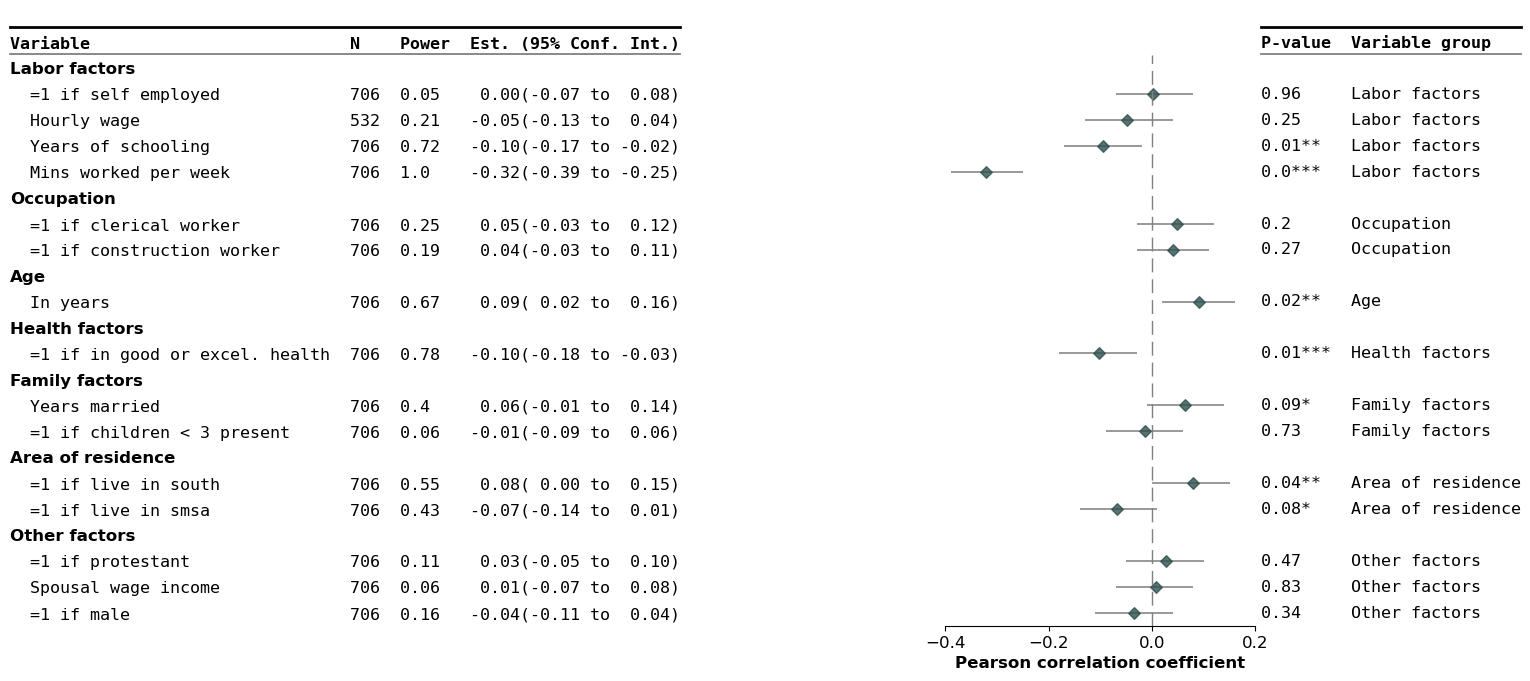

In [33]:
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="p-val",  # column containing p-values to be formatted
              annote=["n", "power", "est_ci"],  # columns to report on left of plot
              annoteheaders=["N", "Power", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              rightannote=["formatted_pval", "group"],  # columns to report on right of plot 
              right_annoteheaders=["P-value", "Variable group"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=["labor factors", "occupation", "age", "health factors", 
                           "family factors", "area of residence", "other factors"],                   
              xlabel="Pearson correlation coefficient",  # x-label title
              xticks=[-.4,-.2,0, .2],  # x-ticks to be printed
              sort=True,  # sort estimates in ascending order
              table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }  
              )